# Computing planet fluxes


The photometry package contains a class to compute the flux of the planets that are used as primary calibrators in (sub-)mm astronomy. For the gas giants Uranus and Neptune, the class use the ESA models by Moreno et al. for the brightness temperature, and relies on the JPL Horizons for the ephemeris. This notebook illustrate how to predict the flux of a planet.

## Working example:

In [1]:
%matplotlib inline
import numpy as np
import photometry as pt
from astropy import units as u
from astropy.coordinates import Angle
from astropy.time import Time
from matplotlib import pyplot as plt
from matplotlib import gridspec


In [2]:
# initialize the planets
uranus = pt.GiantPlanet('Uranus')
neptune = pt.GiantPlanet('Neptune')

In [3]:
# compute neptune solid angle for one date, and uranus for two
neptune.set_dates(Time('2017-04-20T00:00:00.0'))
neptune_omega = neptune.solid_angle()
uranus.set_dates(Time(['2015-10-15T00:00:00.0','2017-04-20T00:00:00.0']))
uranus_omega =  uranus.solid_angle()

In [4]:
print("neptune solid angle: {}".format(neptune_omega))
print("uranus solid angle: {}".format(uranus_omega))

neptune solid angle: 9.044672375164236e-11 rad2
uranus solid angle: [  2.49967181e-10   2.06228857e-10] rad2


In [5]:
spec_uranus = uranus.spectral_irradiance()
spec_neptune_2017 = neptune.spectral_irradiance()

In [6]:
nika2mm = pt.Passband(file='2mm.NIKA2.pb')
nika1mmH = pt.Passband(file='1mmH.NIKA2.pb')
nika1mmV = pt.Passband(file='1mmV.NIKA2.pb')

Here we will use the fnu_ab() method to compute the planet fluxes. Basically AB convention quote the flux that a source that was generating the same response as our objcet would have with a spectrum $S^0_\nu$=cte. 

$\int T_{\nu} S^0_{\nu} d\nu = \int S_{\nu} T_{\nu} d\nu$

Where $T_{\nu}$ is the system response. 

So that:

$  S^0_{\nu} = \frac{\int S_{\nu} T_{\nu} d\nu}{\int T_{\nu} d\nu}$



In [7]:
nika2mm.fnu_ab?

In [8]:
print("Uranus fluxes in 2017:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_uranus).to(u.Jy)[1],
                     nika2mm.fnu_ab(spec_uranus).to(u.Jy)[1],
                     nika1mmV.fnu_ab(spec_uranus).to(u.Jy)[1]))
# Recall that 2017 is the second spectrum..

Uranus fluxes in 2017:
1mmH: 36.752 Jy | 2mm: 15.002 Jy | 1mmV: 37.389 Jy


In [9]:
# Print all the uranus fluxes
nika2mm.fnu_ab(spec_uranus).to(u.Jy)

<Quantity [ 18.18408287, 15.00229995] Jy>

In [10]:
print("Neptune fluxes in 2017:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy)))


Neptune fluxes in 2017:
1mmH: 15.672 Jy | 2mm: 6.858 Jy | 1mmV: 15.931 Jy


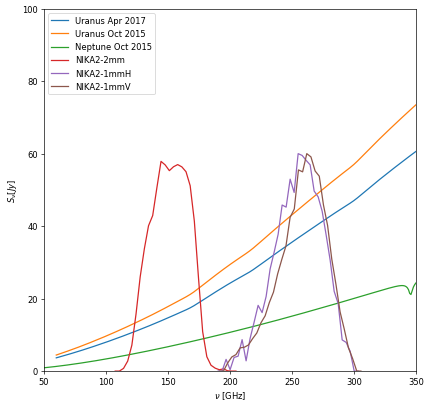

In [11]:
fig1 = plt.figure(1, (8,8), 60)
plt.plot(spec_uranus.nu(u.GHz), (spec_uranus.fnu(u.Jy))[1,:], label='Uranus Apr 2017')
plt.plot(spec_uranus.nu(u.GHz), (spec_uranus.fnu(u.Jy))[0,:], label='Uranus Oct 2015')
plt.plot(spec_neptune_2017.nu(u.GHz), spec_neptune_2017.fnu(u.Jy), label='Neptune Oct 2015')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu} [Jy]$')
plt.axis([50, 350, 0, 100])
plt.plot(nika2mm.nu(u.GHz), nika2mm.y*60., label='NIKA2-2mm')
plt.plot(nika1mmH.nu(u.GHz), nika1mmH.y*60., label='NIKA2-1mmH')
plt.plot(nika1mmV.nu(u.GHz), nika1mmV.y*60., label='NIKA2-1mmV')
plt.legend(loc='upper left', frameon=True)





## Alternative photometric systems

In NIKA, the NIKA2 predecessor, a different convention for quoting fluxes was used:

$ S_{\nu_{0}}= S_{\nu_{0}}^{c} \frac{\int S_{\nu} T_{\nu} d \nu }{\int S_{\nu}^{c} T_{\nu} d \nu} $

Where $S_{\nu}$ is the spectrum of the object, and $S_{\nu}^{c}$ is the spectrum of the calibrator, and $\nu_{0}$ is the reference frequency of the band. In other word, the quoted flux is the the flux that the would planet have at the reference frequency $\nu_{0}$ in order to generate the same response from the instrument as the object.

So the flux used for the planet are the one at the reference frequency. Here is how to obtain them:

In [12]:
print(nika1mmH.xref(u.GHz))
print(spec_uranus.fnu_nu(nika1mmH.xref(u.GHz)).to(u.Jy))

260.0 GHz
[ 45.96135186  37.91920614] Jy


In [13]:
print(nika1mmV.xref(u.GHz))
print(spec_uranus.fnu_nu(nika1mmV.xref(u.GHz)).to(u.Jy))

260.0 GHz
[ 45.96135186  37.91920614] Jy


In [14]:
print(nika2mm.xref(u.GHz))
print(spec_uranus.fnu_nu(nika2mm.xref(u.GHz)).to(u.Jy))

150.0 GHz
[ 17.79495937  14.68126382] Jy


## On the planetary models atmosphere.

If you have read the docstring of the GiantPlanet class, you may have realized that there are more than one model for each planet. The computations we did for both planets used the  version 4 of ESA models for Herschel calibration of 'esa4' for short. There is a version 5 for both planets, but it has been approved only for neptune. Let's check the differences for a few passbands. 

In [15]:
# Load the model
neptunev5 = pt.GiantPlanet('Neptune', model_version='esa5')

In [16]:
neptunev5.set_dates(Time('2017-04-20T00:00:00.0'))
neptunev5_omega = neptune.solid_angle()
print('neptunev5_omega = {:0.03g}. It should be equal to neptunev4_omega{:0.3g} because we are using the same ephemeris in both cases'.format(neptunev5_omega, neptune_omega))


neptunev5_omega = 9.04e-11 rad2. It should be equal to neptunev4_omega9.04e-11 rad2 because we are using the same ephemeris in both cases


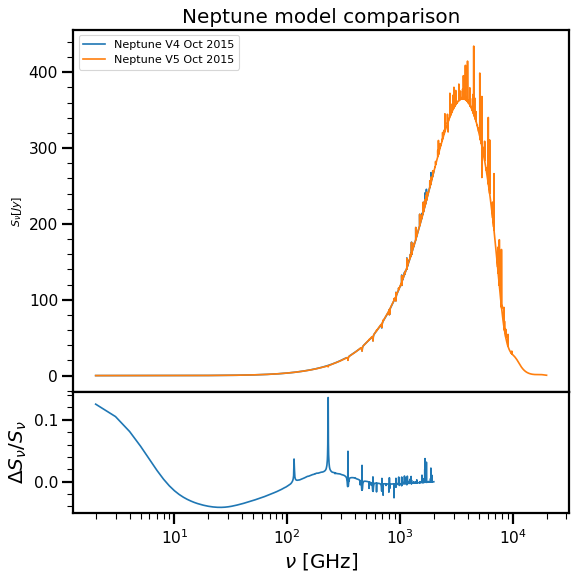

In [17]:
spec_neptune_v5 = neptunev5.spectral_irradiance()

fig = plt.figure(1, (8,8), 80)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.subplots_adjust(hspace=0.0)
ax1 = plt.subplot(gs[0])
ax1.set_xscale("log", nonposy='clip')
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=2, which='major')
ax1.tick_params('both', length=5, width=1, which='minor')
ax1.tick_params(axis='y', which='major', labelsize=14)
ax1.set_title('Neptune model comparison', fontdict={'fontsize':18})
plt.plot(spec_neptune_2017.nu(u.GHz), spec_neptune_2017.fnu(u.Jy), label='Neptune V4 Oct 2015')
plt.plot(spec_neptune_v5.nu(u.GHz), spec_neptune_v5.fnu(u.Jy), label='Neptune V5 Oct 2015')
plt.ylabel(r'$S_{\nu} [Jy]$')
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
ax1.autoscale(False)  
ax1.set_xlim([0, 1000])
plt.legend(loc='upper left')


ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.minorticks_on()
ax2.tick_params('both', length=10, width=2, which='major')
ax2.tick_params('both', length=5, width=1, which='minor')
ax2.tick_params(axis='both', which='major', labelsize=14)

# Note on how we interpolate the spectrum of the second model at the frequencies of the first
# by using the fnu_nu() method instead of the fnu()
plt.plot(spec_neptune_2017.nu(u.GHz), (spec_neptune_2017.fnu(u.Jy)-\
         spec_neptune_v5.fnu_nu(spec_neptune_2017.nu(u.GHz)))/spec_neptune_2017.fnu(u.Jy))
         
         
plt.ylabel(r'$\Delta S_{\nu}/ S_{\nu}$', fontsize=18)
plt.xlabel(r'$\nu$ [GHz]', fontsize=18)

for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(2)
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
labels = ax2.get_yticklabels()
(labels[-1]).set_visible(False)




In [18]:
# Differences in the NIKA2 passbands
print("Neptune fluxes in V4:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy)))

print("Neptune fluxes in V5:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_neptune_v5).to(u.Jy),
                     nika2mm.fnu_ab(spec_neptune_v5).to(u.Jy),
                     nika1mmV.fnu_ab(spec_neptune_v5).to(u.Jy)))

print("Differences:")
print('1mmH: {0:0.03f}% | 2mm: {1:0.03f}% | 1mmV: {2:0.03f}%'.
          format((nika1mmH.fnu_ab(spec_neptune_v5).to(u.Jy) - \
                  nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy)) / \
                 nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy)*100.,
                (nika2mm.fnu_ab(spec_neptune_v5).to(u.Jy)- \
                 nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy)) / \
                 nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy) * 100,
                     (nika1mmV.fnu_ab(spec_neptune_v5).to(u.Jy) - \
                 nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy)) / \
                  nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy) * 100))




Neptune fluxes in V4:
1mmH: 15.672 Jy | 2mm: 6.858 Jy | 1mmV: 15.931 Jy
Neptune fluxes in V5:
1mmH: 15.382 Jy | 2mm: 6.798 Jy | 1mmV: 15.654 Jy
Differences:
1mmH: -1.847% | 2mm: -0.864% | 1mmV: -1.737%


# Under the hood:

## Planet solid angle:

$r_{p-a} = r_{eq} \sqrt{1 - e^{2} cos^{2} \phi}$

where $\phi$ is the sub observer latitude.

$e = \sqrt{\frac{r_{eq}^{2} - r_{p}^{2}}{r_{p}^2}}$

So we have the geometric radius:

$r_{gm} = \sqrt{r_{eq} r_{p-a}}$

And finally the solid angle under which uranus is seen is:

$\Omega = \pi \left(\frac{r_{gm}}{d}\right)^{2}$ 

where $d$ is the distance planet to observer.

## Planet spectral irradiance:

We use ESA V4 model that tabulates the brightness temperature of Uranus as a function of the frequency. From this we can compute the incident spectral irradiance on the detector:

$ S_{\nu} = \Omega \times \frac{ 2 h \nu^{3}}{c^{2}} \frac{1}{e^{\frac{h \nu}{k T_{b}}} -1}$

The file contains a value of $S_{\nu}$ computed using 3.5" of angular diameter for Uranus and 2.3" for Neptune.

Alternativeley, we could use the Rayleigh-Jean temperature where:

$ S_{\nu} = \Omega \times \frac{2  \nu^{2} k T_{RJ}}{c^{2}} $

The code implement the full derivation.

Since both the 1mmH and 1mmV have the same reference frequency, the planet flux is the same for both. This is why the convention adopted was changed. An other possibility would have to have to different reference frequencies for the two bands, acknowledging that they are different. Their difference though is not that large: when taking into account the atmosphere, passband change with elevation as can be seen in the irampassband_howto notebook.

In [19]:
# Let's check the code:
check_ang = Angle(3.5/2. * u.arcsec)
check_omega = np.pi * check_ang**2
uranus_test = uranus.spectral_irradiance(solid_angle=check_omega)
check_ang = Angle(2.3/2. * u.arcsec)
check_omega = np.pi * check_ang**2
neptune_test = neptune.spectral_irradiance(solid_angle=check_omega)

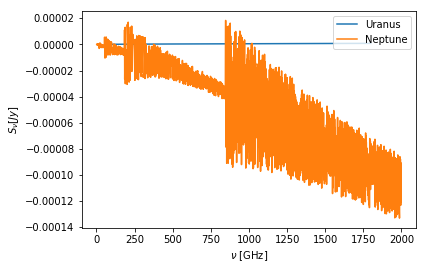

In [20]:
plt.plot(uranus.model['wave'].quantity, 
         (uranus.model['flux'].quantity - uranus_test.fnu_nu(uranus.model['wave'].quantity))/
          uranus.model['wave'].quantity, label='Uranus')
plt.plot(neptune.model['wave'].quantity, 
         (neptune.model['flux'].quantity - neptune_test.fnu_nu(neptune.model['wave'].quantity))/
          neptune.model['wave'].quantity, label='Neptune')

plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu} [Jy]$')
plt.legend(loc='upper right')
# OK


How important is it to take into account the shape of the planet. A easier computation would be to just scale the model spectrum computed for 3.5" with the angular diameter, without taking the aspect ratio into account. We can look at the effect of this.

In [21]:
# let's look at the variation over 10 years, one point every 10 days
times = Time(np.arange(Time('2010-01-01T12:00:00').jd, 
                       Time('2020-01-01T12:00:00').jd, 20), format='jd')

neptune.set_dates(times)
uranus.set_dates(times)

True

In [22]:
from scipy import interpolate

uranus_int = interpolate.interp1d(uranus.ephemeris['JulDate'], \
                                  uranus.ephemeris['AngDiam'], kind='linear')
    
omega_simple_uranus = np.pi * (uranus_int(times.jd)*u.arcsec / 2)**2

omega_full_uranus = uranus.solid_angle()

In [23]:
neptune_int = interpolate.interp1d(neptune.ephemeris['JulDate'], \
                                  neptune.ephemeris['AngDiam'], kind='linear')
    
omega_simple_neptune = np.pi * (neptune_int(times.jd)*u.arcsec / 2)**2

omega_full_neptune = neptune.solid_angle()

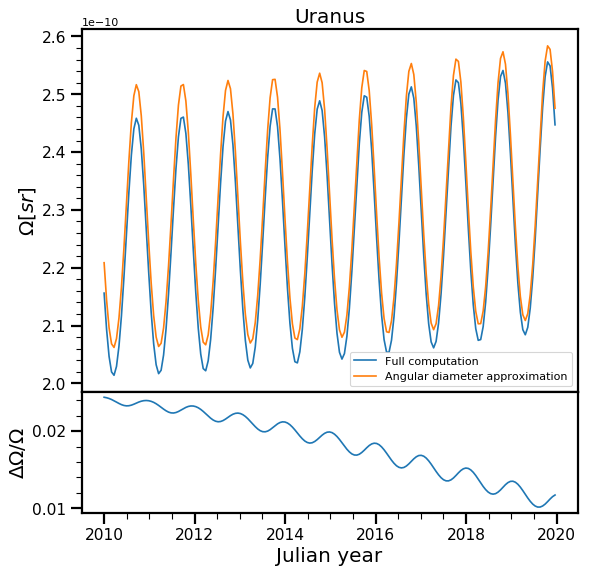

In [24]:
fig = plt.figure(1, (8,8), 80)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.subplots_adjust(hspace=0.0)
ax1 = plt.subplot(gs[0])

ax1.minorticks_on()
ax1.tick_params('both', length=10, width=2, which='major')
ax1.tick_params('both', length=5, width=1, which='minor')
ax1.tick_params(axis='y', which='major', labelsize=14)
ax1.set_title('Uranus', fontdict={'fontsize':18})
plt.plot(times.jyear, omega_full_uranus, label='Full computation')
plt.plot(times.jyear, omega_simple_uranus.to(u.sr), label='Angular diameter approximation')
plt.ylabel(r'$\Omega [sr]$', fontsize=18)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
ax1.autoscale(False)    
plt.legend(loc='lower right')
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.minorticks_on()
ax2.tick_params('both', length=10, width=2, which='major')
ax2.tick_params('both', length=5, width=1, which='minor')
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.plot(times.jyear, (omega_simple_uranus.to(u.sr)-omega_full_uranus)/omega_full_uranus)
plt.ylabel(r'$\Delta \Omega/ \Omega$', fontsize=18)
plt.xlabel(r'Julian year',fontsize=18)


for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(2)
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
labels = ax2.get_yticklabels()
(labels[-1]).set_visible(False)



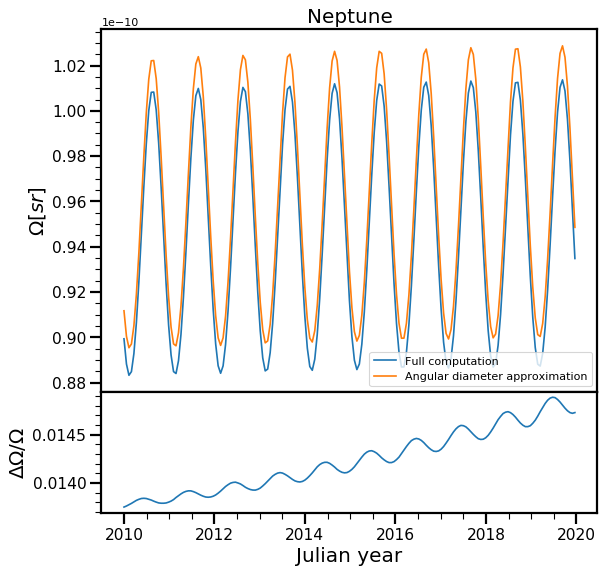

In [25]:
fig = plt.figure(1, (8,8), 80)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.subplots_adjust(hspace=0.0)
ax1 = plt.subplot(gs[0])

ax1.minorticks_on()
ax1.tick_params('both', length=10, width=2, which='major')
ax1.tick_params('both', length=5, width=1, which='minor')
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.plot(times.jyear, omega_full_neptune, label='Full computation')
plt.plot(times.jyear, omega_simple_neptune.to(u.sr), label='Angular diameter approximation')
plt.ylabel(r'$\Omega [sr]$', fontsize=18)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
ax1.set_title('Neptune', fontdict={'fontsize':18})
ax1.autoscale(False)    
plt.legend(loc='lower right')
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.minorticks_on()
ax2.tick_params('both', length=10, width=2, which='major')
ax2.tick_params('both', length=5, width=1, which='minor')
ax2.tick_params(axis='both', which='major', labelsize=14)
plt.plot(times.jyear, (omega_simple_neptune.to(u.sr)-omega_full_neptune)/omega_full_neptune)
plt.ylabel(r'$\Delta \Omega/ \Omega$', fontsize=18)
plt.xlabel(r'Julian year',fontsize=18)


for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(2)
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
labels = ax2.get_yticklabels()
(labels[-1]).set_visible(False)

